<a href="https://colab.research.google.com/github/arfianaja/training/blob/main/yogavgg16ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow roboflow

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from roboflow import Roboflow

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="Ur2qSlP0YGCskFpWYjXX")
project = rf.workspace("yoga-aprilia").project("clasification_clouds")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to clasification_clouds-1 in folder:: 100%|██████████| 4975/4975 [00:00<00:00, 8841.11it/s]


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # set split untuk validasi
)

train_generator = train_datagen.flow_from_directory(
    dataset.location,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset.location,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3964 images belonging to 3 classes.
Found 990 images belonging to 3 classes.


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 2s 0us/step


In [6]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)


In [7]:
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25
)

Epoch 1/25
123/123 [==============================] - 89s 646ms/step - loss: 1.3305 - accuracy: 0.8128 - val_loss: 0.6692 - val_accuracy: 0.8677
Epoch 2/25
123/123 [==============================] - 74s 599ms/step - loss: 0.4897 - accuracy: 0.8431 - val_loss: 0.5769 - val_accuracy: 0.8719
Epoch 3/25
123/123 [==============================] - 74s 600ms/step - loss: 0.4142 - accuracy: 0.8581 - val_loss: 0.4755 - val_accuracy: 0.8458
Epoch 4/25
123/123 [==============================] - 74s 601ms/step - loss: 0.3468 - accuracy: 0.8721 - val_loss: 0.6855 - val_accuracy: 0.8750
Epoch 5/25
123/123 [==============================] - 73s 598ms/step - loss: 0.3509 - accuracy: 0.8699 - val_loss: 0.4691 - val_accuracy: 0.8708
Epoch 6/25
123/123 [==============================] - 74s 600ms/step - loss: 0.3161 - accuracy: 0.8815 - val_loss: 0.4223 - val_accuracy: 0.8646
Epoch 7/25
123/123 [==============================] - 73s 595ms/step - loss: 0.3126 - accuracy: 0.8817 - val_loss: 0.4580 - val_ac

In [11]:
!pip install tensorflow roboflow scikit-learn matplotlib seaborn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

31/31 [==============================] - 34s 1s/step


In [13]:
print('Classification Report')
target_names = list(validation_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

        test       0.12      0.18      0.14        61
       train       0.88      0.86      0.87       867
       valid       0.09      0.06      0.07        62

    accuracy                           0.77       990
   macro avg       0.36      0.37      0.36       990
weighted avg       0.78      0.77      0.78       990



In [14]:
conf_matrix = confusion_matrix(y_true, y_pred)

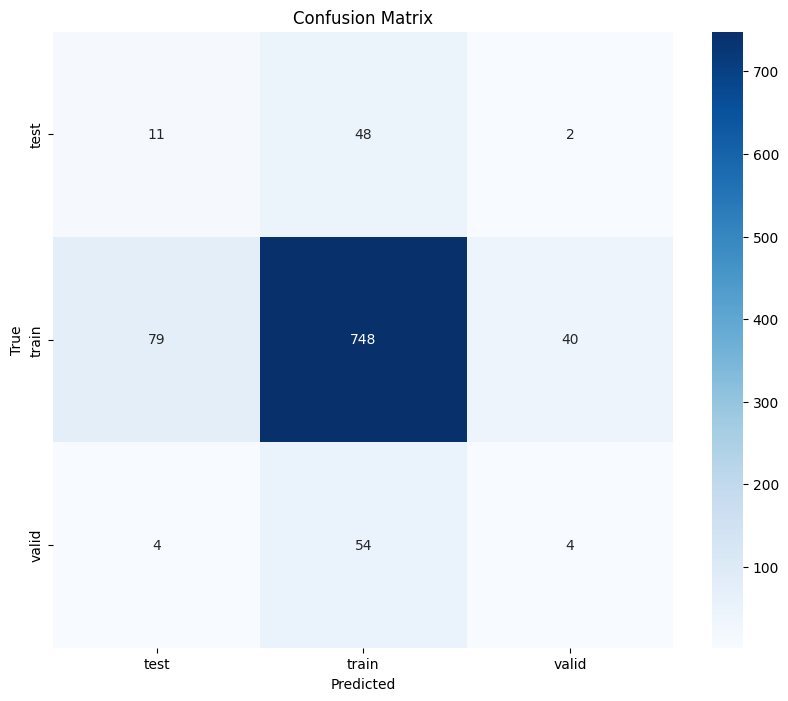

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

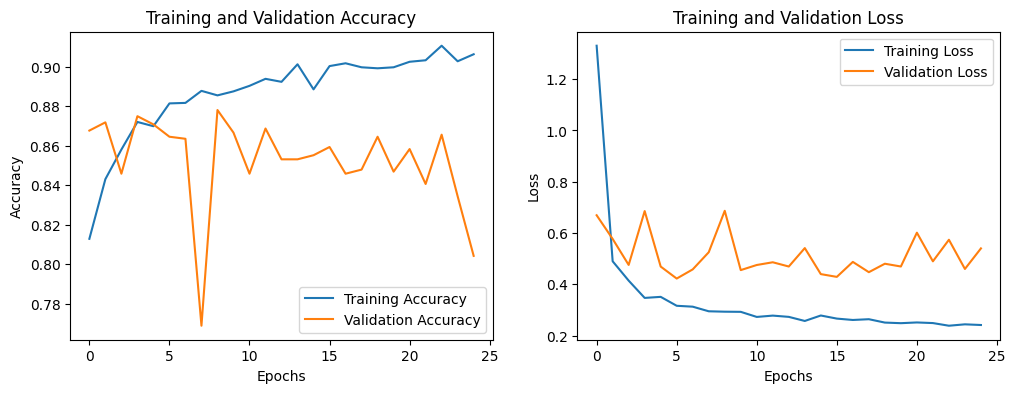

In [24]:

# Plot grafik akurasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
from tensorflow.keras.models import load_model

In [16]:
model.save('vgg16_model.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [21]:
model = load_model('vgg16_model.h5')

In [22]:
def prepare_image(file_path, target_size=(224, 224)):
    img = load_img(file_path, target_size=target_size)  # Memuat gambar dan mengubah ukurannya
    img_array = img_to_array(img)  # Mengubah gambar menjadi array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
    img_array = img_array / 255.0  # Normalisasi gambar
    return img_array

# Path ke gambar tunggal
image_path = '/content/cumulus-1-_jpg.rf.ee3ac3ba02bc30385e9faa5a661b2e8e.jpg'  # Ganti dengan path ke gambar Anda

# Mempersiapkan gambar
image = prepare_image(image_path)

NameError: name 'load_img' is not defined

In [ ]:
# Melakukan prediksi pada gambar tunggal
prediction = model.predict(image)

# Mengambil kelas dengan probabilitas tertinggi
predicted_class = np.argmax(prediction, axis=1)[0]

# Mapping kelas indeks ke nama kelas
class_indices = {v: k for k, v in train_generator.class_indices.items()}
predicted_class_name = class_indices[predicted_class]

# Menampilkan hasil prediksi
print(f"Predicted Class: {predicted_class_name}")


In [ ]:
# Menampilkan gambar dan hasil prediksi
plt.imshow(load_img(image_path))
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis('off')
plt.show()
